# Implementation

[Relationship between PCA and SVD](https://stats.stackexchange.com/a/134283)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from packages.GramSchmidt import gram_schmidt
from packages.SVD import svd_thin

# Codes

## Generating dataset

In [4]:
data = make_classification(n_redundant=0, 
                           n_samples=10**6, weights=[0.9], random_state= 42, )

$\large \mathbf{X} = {\begin{pmatrix} x_{1,1}&\cdots&x_{1,p} \\ \vdots & \ddots &\vdots \\ x_{n,1}&\cdots&x_{n,p} \end{pmatrix} }_{n\times p} = {\begin{pmatrix} X_1 & \cdots&X_p \end{pmatrix} }_{n\times p}$ where $n$ is the number of samples and $p$ is the number of features.

In [5]:
data_x = data[0]
data_y = data[1]

print('shape of X:', data_x.shape)

shape of X: (1000000, 20)


$\large \mathbf{X}_{\normalsize standardized} = \begin{pmatrix} \frac{X_1 -  \mu_1}{\sigma_1} & \frac{X_2 -  \mu_2}{\sigma_2} & \cdots &\frac{X_p -  \mu_p}{\sigma_p}  \end{pmatrix} $, where $\mu_i$ and $\sigma_i$ are mean and standard deviation of a vector $X_i$ for $i \in \{1,2,\cdots,p\}$.

Therefore, the means of each column of matrix $\mathbf{X}_{\normalsize standardized}$ are all 0 and standard deviations are all 1.

In [6]:
scaler = StandardScaler()
data_x_std = scaler.fit_transform(data_x)

print('means of each columns are all 0?:', np.allclose(data_x_std.mean(axis=0), np.zeros(data_x_std.shape)))
print('standard deviations of each columns are all 1?:', np.allclose(data_x_std.std(axis=0), np.ones(data_x_std.shape)))

means of each columns are all 0?: True
standard deviations of each columns are all 1?: True


Reduce the dimension of the maxrix $X$ from $p$ to $2$.

In [7]:
dim_reduced = 2

## Using scikit-learn

In [9]:
start = time.time()

pca = PCA(n_components= dim_reduced, svd_solver='full')
xpca = pca.fit_transform(data_x_std)

end = time.time()
print('runtime:', end - start)

runtime: 0.8331811428070068


The amount of variance explained by each of the selected components.

The 0th component of explained_variance_ equals to variance of 0th column of the matrix $X_{pca}$ with $ddof = 1$.

In [10]:
pca.explained_variance_

array([1.07743561, 1.00654863])

```
pca = PCA()
X_pca = pca.fit_transform(X)
pca.explained_variance_ == X_pca.var(ddof=1, axis=0)
```

In [11]:
print('pca.explained_variance_ == xpca.var(ddof=1, axis=0)?:', np.allclose(pca.explained_variance_, xpca.var(ddof=1, axis=0)))

pca.explained_variance_ == xpca.var(ddof=1, axis=0)?: True


$\large  Comp = \begin{bmatrix} V_{comp1} & V_{comp2} \end{bmatrix}$ 

In [12]:
pca.components_.T

array([[-0.70599712, -0.02179824],
       [-0.03820457, -0.29716737],
       [-0.00511981,  0.24191311],
       [ 0.00316976, -0.1552799 ],
       [-0.00607306,  0.19315766],
       [ 0.01378161, -0.31379142],
       [ 0.01395261, -0.19963659],
       [-0.01303674, -0.10695125],
       [ 0.00663818,  0.12910551],
       [-0.01650511, -0.02872533],
       [ 0.00849686,  0.44358762],
       [-0.01663547, -0.19563718],
       [-0.00496126,  0.17365063],
       [-0.01661978,  0.05243992],
       [ 0.02078452, -0.28187502],
       [-0.01667663,  0.14918825],
       [-0.00635741,  0.06491868],
       [ 0.7051932 , -0.00858833],
       [-0.00136236, -0.16749529],
       [-0.02155668,  0.47118897]])

$\large \lVert V_{comp1} \rVert = \lVert V_{comp2} \rVert = 1$ 

$\large V_{comp1} \perp V_{comp2}$

In [13]:
(pca.components_).dot(pca.components_.T)

array([[1.00000000e+00, 9.03251854e-17],
       [9.03251854e-17, 1.00000000e+00]])

$\large X_{pca} = X_{standardized} \times Comp = X_{standardized} \times \begin{bmatrix} V_{comp1} & V_{comp2} \end{bmatrix}$

In [14]:
print('xpca == data_x_std.dot(pca.components_.T)?:', np.allclose(xpca, data_x_std.dot(pca.components_.T)))

xpca == data_x_std.dot(pca.components_.T)?: True


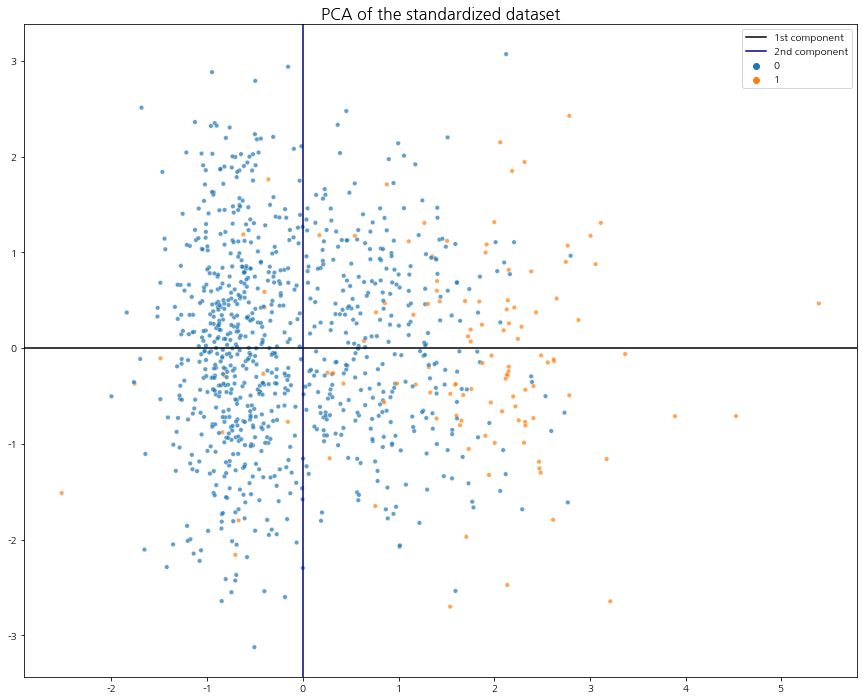

In [15]:
fig, ax = plt.subplots(1,1, figsize = (16,12))
ax.set_aspect(1)
ax.axline((.0, .0), (pca.transform(pca.components_)[0,0], pca.transform(pca.components_)[0,1]), c='k', label='1st component')
ax.axline((.0, .0), (pca.transform(pca.components_)[1,0], pca.transform(pca.components_)[1,1]), c='navy', label='2nd component')

show_n_samp = 1000
sns.scatterplot(x = xpca[:show_n_samp, 0], y=xpca[:show_n_samp, 1], hue=data_y[:show_n_samp],  alpha=.7 , s=20)
plt.title('PCA of the standardized dataset', fontsize = 16)
plt.show()

## Using numpy

### with EVD of covariance matrix

$\displaystyle \large \mathrm{Cov}(X) = {\begin{pmatrix} \mathrm{cov}[X_1, X_1] & \cdots & \mathrm{cov}[X_1, X_p] \\ \vdots & \ddots &\vdots \\ \mathrm{cov}[X_p, X_1] & \cdots & \mathrm{cov}[X_p, X_p]\end{pmatrix}}_{p\times p} = {\begin{pmatrix} \mathrm{var}[X_1] & \cdots & \mathrm{cov}[X_1, X_p] \\ \vdots & \ddots &\vdots \\ \mathrm{cov}[X_p, X_1] & \cdots & \mathrm{var}[X_p]\end{pmatrix}}_{p\times p}$

In [16]:
cov = np.cov(data_x_std, rowvar=False)

If a matrix is already standardized, $\large \mathrm{Cov}(X) = \frac{1}{n-1} X^T X$ where n is the number of samples i.e. rows.

In [17]:
np.allclose(cov, (data_x_std.T).dot(data_x_std)/(data_x_std.shape[0]-1))

True

$\large \mathrm{cov}[X_i, X_j] = \mathrm{cov}[X_j, X_i] \ \ \normalsize \forall i, j \in \{1,2,\dots,p\}$ and all covariance values are real.

Therefore $\large \mathrm{Cov}(X)$ is **symmetric** 

i.e. $\large \mathrm{Cov}(X) = \left [ \mathrm{Cov}(X) \right ]^T$

In [18]:
np.alltrue(cov == np.conjugate(cov).T)

True

$\large Q$ is a set of eigenvectors of $\mathrm{Cov}(X)$.

$\large \Lambda$ is a diagonal square matrix whose diagonal entries are eigenvalues of $\mathrm{Cov}(X)$.

In [19]:
evalues, evectors = np.linalg.eig(cov)
evalues_mat = np.sort(evalues)[::-1] * np.eye(evalues.size)

In [20]:
np.allclose((np.conjugate(evectors).T).dot(evectors), np.eye(evectors.shape[1]))

True

* Sort the columns of $\large V$ in descending order of those eigenvalues.

In [21]:
evectors = evectors[:,evalues.argsort()[::-1]]

$\large \mathrm{Cov}(X) = Q \Lambda Q^{-1} = Q \Lambda Q^T$

In [22]:
np.allclose(cov, evectors.dot(evalues_mat.dot(evectors.T)))

True

$\large X_{pca} = X_{standardized} \times \begin{bmatrix} V_{1} & V_{2} \end{bmatrix}$ where v1, v2 are the first two columns of eigenvectors $Q$.

In [23]:
data_x_pca = data_x_std.dot(evectors[:,:dim_reduced])
comp_reduced = (evectors[:,:dim_reduced].T).dot(evectors[:,:dim_reduced])

* Visualization: the same as the x-axis reflection of above scatter plot

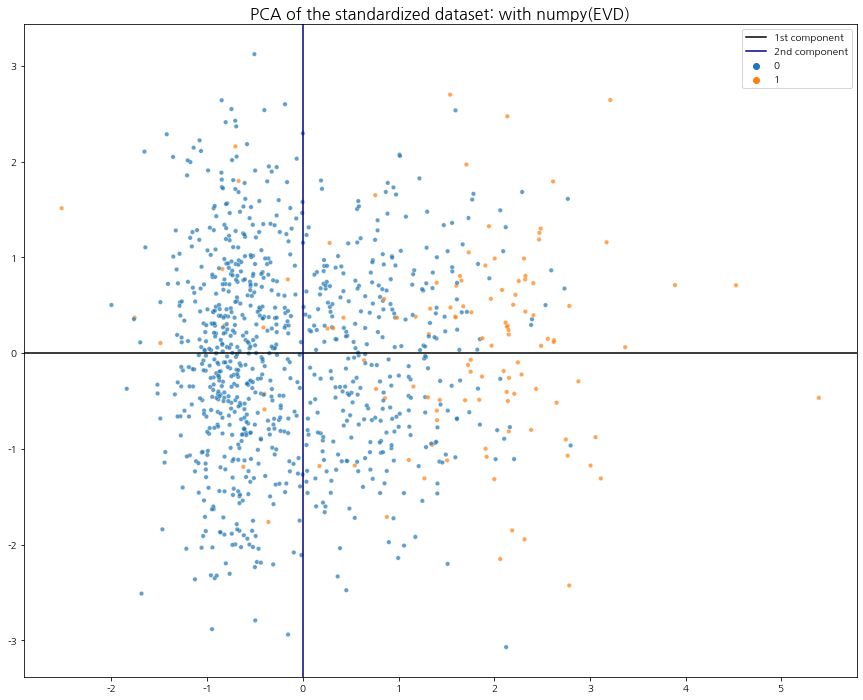

In [24]:
fig, ax = plt.subplots(1,1, figsize = (16,12))
ax.set_aspect(1)

ax.axline((.0, .0), (comp_reduced[0,0], comp_reduced[0,1]), c='k', label='1st component')
ax.axline((.0, .0), (comp_reduced[1,0], comp_reduced[1,1]), c='navy', label='2nd component')

show_n_samp = 1000
sns.scatterplot(x = data_x_pca[:show_n_samp, 0], y=data_x_pca[:show_n_samp, 1], hue=data_y[:show_n_samp],  alpha=.7 , s=20)
plt.title('PCA of the standardized dataset: with numpy(EVD)', fontsize = 16)
plt.show()

### with SVD of dataset

$\large X = U S V^*$

In [8]:
# with numpy SVD

start = time.time()

u, s, vh = np.linalg.svd(data_x_std, full_matrices=False)

xpca1 = data_x_std.dot(vh.T)[:,:dim_reduced]
end = time.time()
print(end - start)

0.7632288932800293


In [9]:
# with the implemented SVD by my code

start = time.time()

u, s, v = svd_thin(data_x_std, )

xpca1 = data_x_std.dot(v[:,:dim_reduced])
end = time.time()
print(end - start)

0.3131856918334961


$\large U^* U  = I$

In [27]:
np.allclose(np.conjugate(u).T.dot(u), np.eye(u.shape[1]))

True

In [28]:
np.allclose(abs(xpca), abs(xpca1))

True

$\large \mathrm{Cov}(X) =\frac{1}{n-1} X^* X =\frac{1}{n-1}  V S^* U^* U S V^* =\frac{1}{n-1} V S^* I S V^* =\frac{1}{n-1}  V S^2 V^* = Q \Lambda Q^T $

$\therefore$ By SVD, we can get component vectors for PCA faster than by Eigenvalue decomposition(EVD) of covariance matrix. 

$\large V = Q$

In [29]:
np.allclose(evectors, v)

True

* $X_{pca}$ with SVD equals to $X_{pca}$ with EVD

In [30]:
np.allclose(data_x_pca, xpca1)

True

In [31]:
comp_reduced1 = (v[:,:dim_reduced].T).dot(v[:,:dim_reduced])

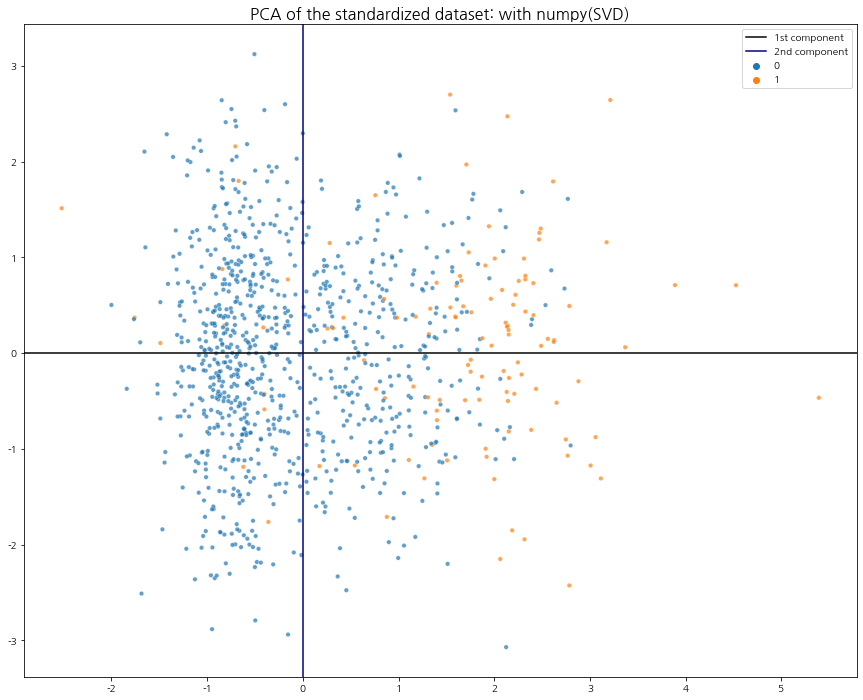

In [32]:
fig, ax = plt.subplots(1,1, figsize = (16,12))
ax.set_aspect(1)

ax.axline((.0, .0), (comp_reduced1[0,0], comp_reduced1[0,1]), c='k', label='1st component')
ax.axline((.0, .0), (comp_reduced1[1,0], comp_reduced1[1,1]), c='navy', label='2nd component')

show_n_samp = 1000
sns.scatterplot(x = xpca1[:show_n_samp, 0], y=xpca1[:show_n_samp, 1], hue=data_y[:show_n_samp],  alpha=.7 , s=20)
plt.title('PCA of the standardized dataset: with numpy(SVD)', fontsize = 16)
plt.show()